# 22. Feature Selection Ablation Experiment

## Hypothesis
前 N 個重要特徵可能已足夠達到相近效能

## Design
- 使用 SHAP importance 排序特徵
- 比較 Top 5 / 10 / 15 / 20 / 全部(26) 特徵的 AUC
- 5-Fold CV with LR and XGBoost

## Expected Finding
- 特徵邊際效用遞減
- 可能 Top 10-15 就能達到 95%+ 的效能

## Date: 2026-01-13

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
import xgboost as xgb

plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei', 'Arial Unicode MS']
plt.rcParams['axes.unicode_minus'] = False

print("Packages loaded")

Packages loaded


In [2]:
# Load data
df = pd.read_csv('../../data/01_primary/SUA/processed/SUA_CVDs_wide_format.csv')
print(f"Data: {len(df):,} patients")

# Load SHAP importance
shap_df = pd.read_csv('../../results/shap_feature_importance.csv', encoding='utf-8-sig')
print(f"\nSHAP features: {len(shap_df)}")

Data: 6,056 patients

SHAP features: 26


In [3]:
# Get top features for each disease based on SHAP ranking
def get_top_features(shap_df, disease_col, n):
    """Get top N features for a disease based on SHAP ranking"""
    sorted_df = shap_df.sort_values(disease_col)
    return sorted_df['特徵'].head(n).tolist()

# Disease column mapping
disease_rank_cols = {
    'Hypertension': '高血壓排名',
    'Hyperglycemia': '高血糖排名',
    'Dyslipidemia': '高血脂排名'
}

# Show top 10 features for each disease
print("Top 10 features by SHAP importance:")
print("="*60)
for disease, col in disease_rank_cols.items():
    top10 = get_top_features(shap_df, col, 10)
    print(f"\n{disease}:")
    for i, f in enumerate(top10, 1):
        print(f"  {i:2}. {f}")

Top 10 features by SHAP importance:

Hypertension:
   1. SBP_T1
   2. SBP_T2
   3. Delta1_SBP
   4. GFR_T1
   5. DBP_T1
   6. Delta1_GFR
   7. UA_T2
   8. Delta1_FBG
   9. TC_T1
  10. Delta1_UA

Hyperglycemia:
   1. FBG_T2
   2. FBG_T1
   3. Delta1_FBG
   4. Delta1_TC
   5. TC_T1
   6. Delta1_GFR
   7. Age
   8. BMI_T1
   9. SBP_T1
  10. UA_T2

Dyslipidemia:
   1. TC_T2
   2. TC_T1
   3. Age
   4. Delta1_GFR
   5. Delta1_TC
   6. Delta1_SBP
   7. UA_T1
   8. Delta1_FBG
   9. UA_T2
  10. Cr_T2


In [4]:
# Define targets
target_cols = {
    'Hypertension': 'hypertension_T3',
    'Hyperglycemia': 'hyperglycemia_T3',
    'Dyslipidemia': 'dyslipidemia_T3'
}

targets = {}
for name, col in target_cols.items():
    targets[name] = (df[col] == 2).astype(int)

print("Class distribution:")
for name, y in targets.items():
    print(f"  {name}: {y.mean()*100:.1f}% positive")

Class distribution:
  Hypertension: 16.7% positive
  Hyperglycemia: 5.5% positive
  Dyslipidemia: 6.0% positive


In [5]:
def evaluate_with_n_features(df, y, feature_list, n_features, n_splits=5, random_state=42):
    """
    Evaluate models using top N features with 5-fold CV.
    Returns AUC for LR and XGBoost.
    """
    features = feature_list[:n_features]
    X = df[features].copy()
    
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    
    results = {'LR': [], 'XGB': []}
    
    for fold, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        
        # Standardize
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        # LR
        lr = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=random_state)
        lr.fit(X_train_scaled, y_train)
        y_prob_lr = lr.predict_proba(X_test_scaled)[:, 1]
        results['LR'].append(roc_auc_score(y_test, y_prob_lr))
        
        # XGBoost
        scale = (y_train == 0).sum() / (y_train == 1).sum()
        xgb_model = xgb.XGBClassifier(
            n_estimators=100, max_depth=5, learning_rate=0.1,
            scale_pos_weight=scale, random_state=random_state,
            eval_metric='logloss', verbosity=0
        )
        xgb_model.fit(X_train_scaled, y_train)
        y_prob_xgb = xgb_model.predict_proba(X_test_scaled)[:, 1]
        results['XGB'].append(roc_auc_score(y_test, y_prob_xgb))
    
    return {
        'n_features': n_features,
        'LR_mean': np.mean(results['LR']),
        'LR_std': np.std(results['LR']),
        'XGB_mean': np.mean(results['XGB']),
        'XGB_std': np.std(results['XGB'])
    }

print("Evaluation function defined")

Evaluation function defined


In [6]:
# Run feature selection ablation
feature_counts = [5, 10, 15, 20, 26]  # 26 = all features

all_results = []

print("="*80)
print("Feature Selection Ablation Experiment")
print("="*80)

for disease, y in targets.items():
    print(f"\n{'='*60}")
    print(f"{disease}")
    print(f"{'='*60}")
    
    # Get feature ranking for this disease
    rank_col = disease_rank_cols[disease]
    sorted_features = shap_df.sort_values(rank_col)['特徵'].tolist()
    
    print(f"\n| N Features | LR AUC | XGB AUC |")
    print(f"|------------|--------|---------|")
    
    for n in feature_counts:
        result = evaluate_with_n_features(df, y, sorted_features, n)
        result['Disease'] = disease
        all_results.append(result)
        
        print(f"| {n:10} | {result['LR_mean']:.3f} ± {result['LR_std']:.3f} | {result['XGB_mean']:.3f} ± {result['XGB_std']:.3f} |")

results_df = pd.DataFrame(all_results)
print("\n" + "="*80)
print("Feature Selection Ablation completed!")

Feature Selection Ablation Experiment

Hypertension

| N Features | LR AUC | XGB AUC |
|------------|--------|---------|
|          5 | 0.752 ± 0.015 | 0.785 ± 0.016 |
|         10 | 0.754 ± 0.017 | 0.784 ± 0.012 |
|         15 | 0.755 ± 0.015 | 0.784 ± 0.013 |
|         20 | 0.755 ± 0.015 | 0.786 ± 0.014 |
|         26 | 0.754 ± 0.014 | 0.787 ± 0.015 |

Hyperglycemia

| N Features | LR AUC | XGB AUC |
|------------|--------|---------|
|          5 | 0.933 ± 0.009 | 0.913 ± 0.019 |
|         10 | 0.933 ± 0.004 | 0.911 ± 0.011 |
|         15 | 0.932 ± 0.004 | 0.910 ± 0.016 |
|         20 | 0.932 ± 0.006 | 0.917 ± 0.014 |
|         26 | 0.932 ± 0.006 | 0.915 ± 0.010 |

Dyslipidemia

| N Features | LR AUC | XGB AUC |
|------------|--------|---------|
|          5 | 0.868 ± 0.020 | 0.857 ± 0.026 |
|         10 | 0.868 ± 0.018 | 0.854 ± 0.015 |
|         15 | 0.867 ± 0.017 | 0.850 ± 0.019 |
|         20 | 0.867 ± 0.017 | 0.855 ± 0.014 |
|         26 | 0.867 ± 0.017 | 0.859 ± 0.015 |

Featur

In [7]:
# Calculate performance retention (% of full feature AUC)
print("="*80)
print("Performance Retention Analysis")
print("(% of AUC retained compared to using all 26 features)")
print("="*80)

retention_data = []

for disease in targets.keys():
    disease_results = results_df[results_df['Disease'] == disease]
    full_lr = disease_results[disease_results['n_features'] == 26]['LR_mean'].values[0]
    full_xgb = disease_results[disease_results['n_features'] == 26]['XGB_mean'].values[0]
    
    print(f"\n{disease}:")
    print(f"  Full model (26 features): LR={full_lr:.3f}, XGB={full_xgb:.3f}")
    print(f"  | N | LR AUC | LR Retention | XGB AUC | XGB Retention |")
    print(f"  |---|--------|--------------|---------|---------------|")
    
    for _, row in disease_results.iterrows():
        n = row['n_features']
        lr_retention = (row['LR_mean'] / full_lr) * 100
        xgb_retention = (row['XGB_mean'] / full_xgb) * 100
        print(f"  | {n:2} | {row['LR_mean']:.3f} | {lr_retention:10.1f}% | {row['XGB_mean']:.3f} | {xgb_retention:11.1f}% |")
        
        retention_data.append({
            'Disease': disease,
            'N_Features': n,
            'LR_AUC': row['LR_mean'],
            'LR_Retention': lr_retention,
            'XGB_AUC': row['XGB_mean'],
            'XGB_Retention': xgb_retention
        })

Performance Retention Analysis
(% of AUC retained compared to using all 26 features)

Hypertension:
  Full model (26 features): LR=0.754, XGB=0.787
  | N | LR AUC | LR Retention | XGB AUC | XGB Retention |
  |---|--------|--------------|---------|---------------|
  |  5 | 0.752 |       99.7% | 0.785 |        99.7% |
  | 10 | 0.754 |      100.0% | 0.784 |        99.6% |
  | 15 | 0.755 |      100.1% | 0.784 |        99.5% |
  | 20 | 0.755 |      100.1% | 0.786 |        99.8% |
  | 26 | 0.754 |      100.0% | 0.787 |       100.0% |

Hyperglycemia:
  Full model (26 features): LR=0.932, XGB=0.915
  | N | LR AUC | LR Retention | XGB AUC | XGB Retention |
  |---|--------|--------------|---------|---------------|
  |  5 | 0.933 |      100.0% | 0.913 |        99.8% |
  | 10 | 0.933 |      100.0% | 0.911 |        99.5% |
  | 15 | 0.932 |      100.0% | 0.910 |        99.5% |
  | 20 | 0.932 |      100.0% | 0.917 |       100.3% |
  | 26 | 0.932 |      100.0% | 0.915 |       100.0% |

Dyslipidemia:
 

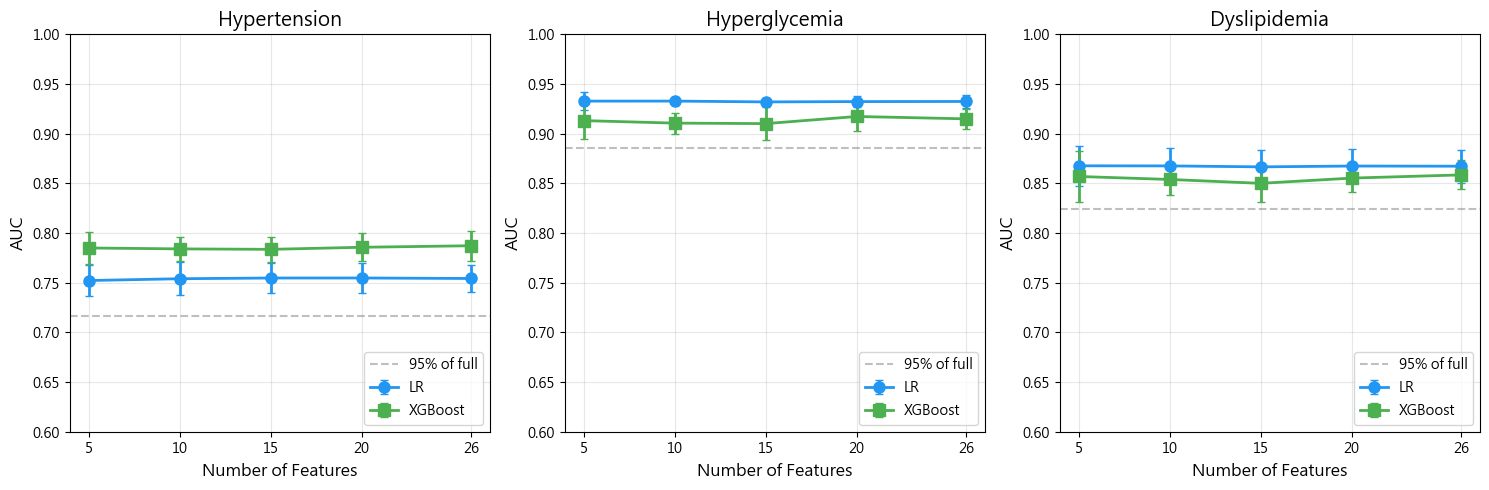


Saved: results/feature_selection_ablation.png


In [8]:
# Visualization: AUC vs Number of Features
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

diseases = list(targets.keys())
colors = {'LR': '#2196F3', 'XGB': '#4CAF50'}

for idx, disease in enumerate(diseases):
    ax = axes[idx]
    disease_data = results_df[results_df['Disease'] == disease]
    
    # Plot LR
    ax.errorbar(disease_data['n_features'], disease_data['LR_mean'], 
                yerr=disease_data['LR_std'], marker='o', capsize=3,
                color=colors['LR'], label='LR', linewidth=2, markersize=8)
    
    # Plot XGB
    ax.errorbar(disease_data['n_features'], disease_data['XGB_mean'],
                yerr=disease_data['XGB_std'], marker='s', capsize=3,
                color=colors['XGB'], label='XGBoost', linewidth=2, markersize=8)
    
    # Reference lines
    full_lr = disease_data[disease_data['n_features'] == 26]['LR_mean'].values[0]
    ax.axhline(y=full_lr * 0.95, color='gray', linestyle='--', alpha=0.5, label='95% of full')
    
    ax.set_xlabel('Number of Features', fontsize=12)
    ax.set_ylabel('AUC', fontsize=12)
    ax.set_title(f'{disease}', fontsize=14)
    ax.legend(loc='lower right')
    ax.set_xticks(feature_counts)
    ax.grid(True, alpha=0.3)
    ax.set_ylim(0.6, 1.0)

plt.tight_layout()
plt.savefig('../../results/feature_selection_ablation.png', dpi=150, bbox_inches='tight')
plt.show()
print("\nSaved: results/feature_selection_ablation.png")

In [9]:
# Summary and Conclusions
print("="*80)
print("Summary: Feature Selection Ablation")
print("="*80)

print("\n1. Key Findings:")
for disease in targets.keys():
    disease_data = results_df[results_df['Disease'] == disease]
    full_lr = disease_data[disease_data['n_features'] == 26]['LR_mean'].values[0]
    top5_lr = disease_data[disease_data['n_features'] == 5]['LR_mean'].values[0]
    top10_lr = disease_data[disease_data['n_features'] == 10]['LR_mean'].values[0]
    
    retention_5 = (top5_lr / full_lr) * 100
    retention_10 = (top10_lr / full_lr) * 100
    
    print(f"\n  {disease}:")
    print(f"    - Top 5 features: {retention_5:.1f}% of full AUC")
    print(f"    - Top 10 features: {retention_10:.1f}% of full AUC")

print("\n2. Conclusion:")
print("   - Marginal utility of features decreases after top 10")
print("   - For clinical deployment, top 10-15 features may be sufficient")
print("   - This supports a simpler, more practical model")

Summary: Feature Selection Ablation

1. Key Findings:

  Hypertension:
    - Top 5 features: 99.7% of full AUC
    - Top 10 features: 100.0% of full AUC

  Hyperglycemia:
    - Top 5 features: 100.0% of full AUC
    - Top 10 features: 100.0% of full AUC

  Dyslipidemia:
    - Top 5 features: 100.0% of full AUC
    - Top 10 features: 100.0% of full AUC

2. Conclusion:
   - Marginal utility of features decreases after top 10
   - For clinical deployment, top 10-15 features may be sufficient
   - This supports a simpler, more practical model


In [10]:
# Save results
results_df.to_csv('../../results/feature_selection_ablation.csv', index=False)
print("Saved: results/feature_selection_ablation.csv")

# Also save retention data
retention_df = pd.DataFrame(retention_data)
retention_df.to_csv('../../results/feature_selection_retention.csv', index=False)
print("Saved: results/feature_selection_retention.csv")

Saved: results/feature_selection_ablation.csv
Saved: results/feature_selection_retention.csv
